In [66]:
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import r2_score, classification_report, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import label_binarize

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:

def plot_confusion_matrix(
    working_dir, cm, target_names, title="Confusion matrix", cmap=None, normalize=False
):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap("Blues")

    plt.figure(figsize=(9, 8))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(
                j,
                i,
                f"{cm[i, j]:0.4f}",
                horizontalalignment="center",
                color="black",
                # color="white" if cm[i, j] > thresh else "black",
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]:,}",
                horizontalalignment="center",
                color="black",
                # color="white" if cm[i, j] > thresh else "black",
            )

    plt.ylabel("True label")
    plt.xlabel(f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}")

    #plt.savefig(os.path.join(working_dir, title + ".pdf"))
    #plt.savefig(os.path.join(working_dir, title + ".png"))
    #plt.clf()


def print_classification_report(y_true, y_pred):
    """
    Prints classification report to stdout.

    Args:
        y_true (nparray): 1D npy array containing int values for class
        y_pred (nparray): 1D npy array containing int values for predicted class
        train_gen (Keras Generator): Training generator used for model training, used for labels
    """
    print("Classification Report")
    print(classification_report(y_true, y_pred))



In [68]:
df = pd.read_csv("AFT_Timesweeper_res.csv")
lab_dict = {0: "neut", 1: "sdn", 2: "ssv"}
dict_lab = {v:k for k,v in lab_dict.items()}
df["str_swp"] = [lab_dict[i] for i in df["pred_sweep"]] 
df["true"] = [dict_lab[i] for i in df["sweep"]]
df.head()

,rep,sweep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,str_swp,true
0,0,neut,0,0.618748,0.056593,0.324659,0.0,0.019733,0.020061,neut,0
1,1,neut,0,0.658379,0.037367,0.304254,0.0,0.019693,0.130083,neut,0
2,10,neut,0,0.668242,0.036735,0.295023,0.0,0.015832,0.118393,neut,0
3,100,neut,0,0.622809,0.051988,0.325204,0.0,0.023465,0.164000,neut,0
4,1000,neut,0,0.679514,0.031193,0.289293,0.0,0.014533,0.151762,neut,0


Classification Report
              precision    recall  f1-score   support

        neut       0.62      0.92      0.74      3051
         sdn       0.66      0.89      0.76      3050
         ssv       0.75      0.13      0.23      3051

    accuracy                           0.65      9152
   macro avg       0.68      0.65      0.58      9152
weighted avg       0.68      0.65      0.58      9152



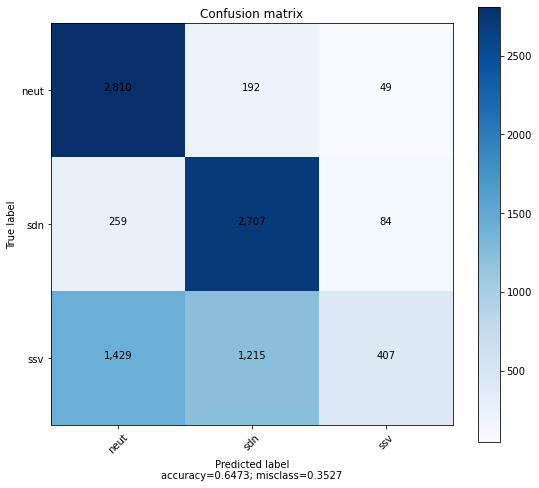

In [69]:
print_classification_report(df["sweep"], df["str_swp"])
plot_confusion_matrix('.', confusion_matrix(df["sweep"], df["str_swp"]), list(lab_dict.values()))


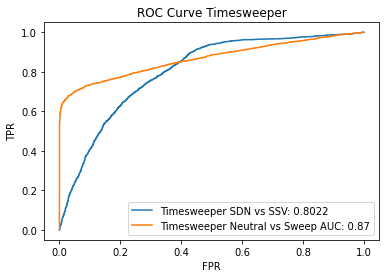

In [70]:
"""Plot ROC curve by binarizing neutral/sweep."""

# Plot sdn/ssv distinction
sweep_idxs = np.transpose(np.array((df["true"] > 0)).nonzero())
sweep_labs = np.array(df["true"])[sweep_idxs]

sdn_probs = df[df["true"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"Timesweeper SDN vs SSV: {swp_auc_val:.4}",
)

# Coerce all ssvs into sweep binary pred
labs = np.array(df["true"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([df["sdn_prob"], df["ssv_prob"]]).T, axis=1)

# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, pred_probs)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Timesweeper Neutral vs Sweep AUC: {auc_val:.2}")

plt.title(f"ROC Curve Timesweeper")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

plt.show()

Text(0, 0.5, 'Precision')

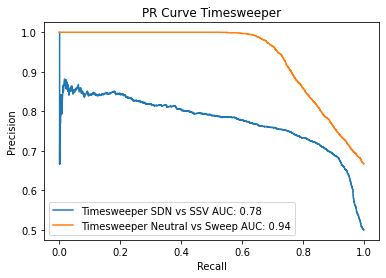

In [71]:
name="Timesweeper"
"""Plot PR curve by binarizing neutral/sweep."""
# Plot sdn/ssv distinction

filt_df = df[(df["sdn_prob"] > 0.0) & (df["ssv_prob"] > 0.0)]

sweep_idxs = np.transpose(np.array((filt_df["true"] > 0)).nonzero())
sweep_labs = np.array(filt_df["true"])[sweep_idxs]

sweep_labs[sweep_labs == 1] = 1
sweep_labs[sweep_labs == 2] = 0

if len(np.unique(filt_df["true"])) > 2:
    sdn_probs = filt_df[filt_df["true"] > 0]["sdn_prob"] / (
        filt_df[filt_df["true"] > 0]["sdn_prob"]
        + filt_df[filt_df["true"] > 0]["ssv_prob"]
    )

    swp_prec, swp_rec, swp_thresh = precision_recall_curve(
        sweep_labs.flatten(), sdn_probs
    )
    swp_auc_val = auc(swp_rec, swp_prec)
    plt.plot(
        swp_rec,
        swp_prec,
        label=f"{name.capitalize()} SDN vs SSV AUC: {swp_auc_val:.2}",
    )

# Coerce all ssvs into sweep binary pred
labs = np.array(df["true"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([df["sdn_prob"], df["ssv_prob"]]).T, axis=1)

# Plot PR Curve for binarized labs
prec, rec, thresh = precision_recall_curve(labs, pred_probs)
auc_val = auc(rec, prec)
plt.plot(rec, prec, label=f"{name.capitalize()} Neutral vs Sweep AUC: {auc_val:.2}")

plt.title(f"PR Curve {name}")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

In [72]:
df.head()

,rep,sweep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,str_swp,true
0,0,neut,0,0.618748,0.056593,0.324659,0.0,0.019733,0.020061,neut,0
1,1,neut,0,0.658379,0.037367,0.304254,0.0,0.019693,0.130083,neut,0
2,10,neut,0,0.668242,0.036735,0.295023,0.0,0.015832,0.118393,neut,0
3,100,neut,0,0.622809,0.051988,0.325204,0.0,0.023465,0.164000,neut,0
4,1000,neut,0,0.679514,0.031193,0.289293,0.0,0.014533,0.151762,neut,0


In [73]:
df.describe()

,rep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,true
count,9152.000000,9152.000000,9152.000000,9152.000000,9152.000000,9152.000000,9152.000000,9152.000000,9152.000000
mean,1525.106534,0.567526,0.322152,0.381560,0.296289,0.068343,0.079099,0.117483,1.000000
std,880.785053,0.602899,0.281431,0.313412,0.095932,0.082362,0.066623,0.052849,0.816586
min,0.000000,0.000000,0.000042,0.014421,0.091897,0.000000,0.010743,-0.003370,0.000000
25%,762.750000,0.000000,0.002663,0.051728,0.236546,0.000000,0.022311,0.071157,0.000000
50%,1525.000000,1.000000,0.370381,0.337045,0.295850,0.019739,0.039161,0.127256,1.000000
75%,2288.000000,1.000000,0.626091,0.723555,0.326770,0.137361,0.145615,0.162241,2.000000
max,3050.000000,2.000000,0.752371,0.907968,0.695826,0.249935,0.230187,0.220416,2.000000


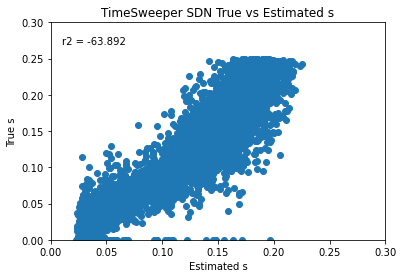

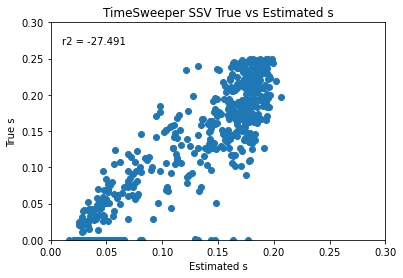

<Figure size 432x288 with 0 Axes>

In [74]:
for swp in df["sweep"].unique():
    subdf = df[df["str_swp"] == swp].dropna()
    if swp == "neut":
        continue
    else:
        plt.scatter(x=subdf[f"{swp}_sval"], y=subdf["s_val"])
        
    plt.xlim(0., .3)
    plt.ylim(0, .3)
    plt.annotate("r2 = {:.3f}".format(r2_score(subdf["s_val"], subdf[f"{swp}_prob"])), (0.01, 0.27))
    plt.title(f"TimeSweeper {swp.upper()} True vs Estimated s") 
    plt.xlabel("Estimated s") 
    plt.ylabel("True s") 
    plt.savefig(f"{swp}_true_v_est_ts.pdf")
    plt.show()
    plt.clf()